## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-x80fvufx
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-x80fvufx
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-ppfnwdwv/cv-algorithms_dcf1ca4bc77849fbab9f1c730435ce9d
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-ppfnwdwv/cv-algorithms_dcf1ca4bc77849fbab9f1c730435ce9d
     |████████████████████████████████| 167 kB 4.7 MB/s 
     |████████████████████████████████| 88.3 MB 79 kB/s 
     |████████████████████████████████| 229 kB 23.9 MB/s 
     |████████████████████████████████| 51 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 54.9 MB/s 
     |████████████████████████████████| 271 kB 51.6 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 45.8 MB/s 
  Created wheel for fatbox: filename=fatbox-0.0.1-py3-none-any.whl size=29

In [2]:
!pip install googledrivedownloader

download the tutorials:

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1RNF_XrfhNwWyBv7MRRDPL1NI0OY2VXbv',
                                    dest_path='./dem_crop2.npy',
                                    unzip=False)

Now we can load the python packages that we need:

In [4]:
!pip install earthpy

     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 30.6 MB/s 
     |████████████████████████████████| 6.3 MB 23.2 MB/s 
     |████████████████████████████████| 16.7 MB 284 kB/s 


In [5]:
import numpy as np 
import networkx as nx
import pickle
import cv2

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from skimage import feature, morphology, filters
from sklearn.preprocessing import normalize

from sys import stdout

import earthpy.spatial as es
import earthpy.plot as ep

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

In [6]:
from matplotlib.colors import LinearSegmentedColormap

for map in plt.colormaps():
  # get colormap
  ncolors = 256
  color_array = plt.get_cmap(map)(range(ncolors))

  # change alpha values
  color_array[:,-1] = np.linspace(0.0,0.5,ncolors)

  # create a colormap object
  map_object = LinearSegmentedColormap.from_list(name= map + '_alpha',colors=color_array)

  # register this new colormap with matplotlib
  plt.register_cmap(cmap=map_object)

## Fault extraction

First, we load our data:

In [7]:
DEM = np.load('/content/dem_crop2.npy')

Now we can plot the DEM with hillshade:

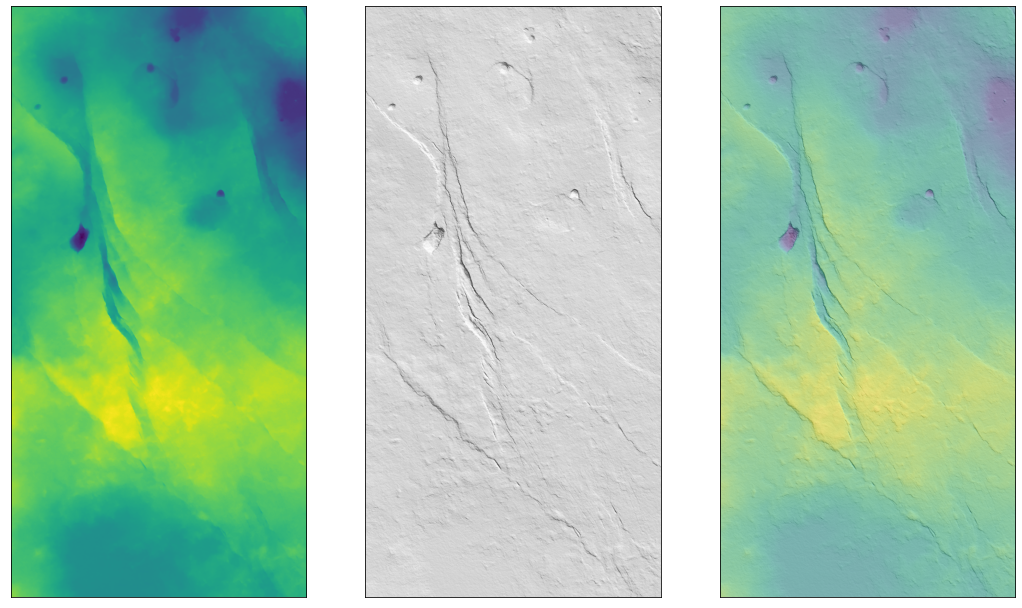

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18,12))

im0 = axs[0].imshow(DEM)
axs[0].set_xticks([])
axs[0].set_yticks([])

ep.plot_bands(es.hillshade(DEM), cbar=False, ax=axs[1])

ep.plot_bands(es.hillshade(DEM), cbar=False, ax=axs[2])
axs[2].imshow(DEM, alpha=0.5)

plt.show()

Now we can calculate the slope:

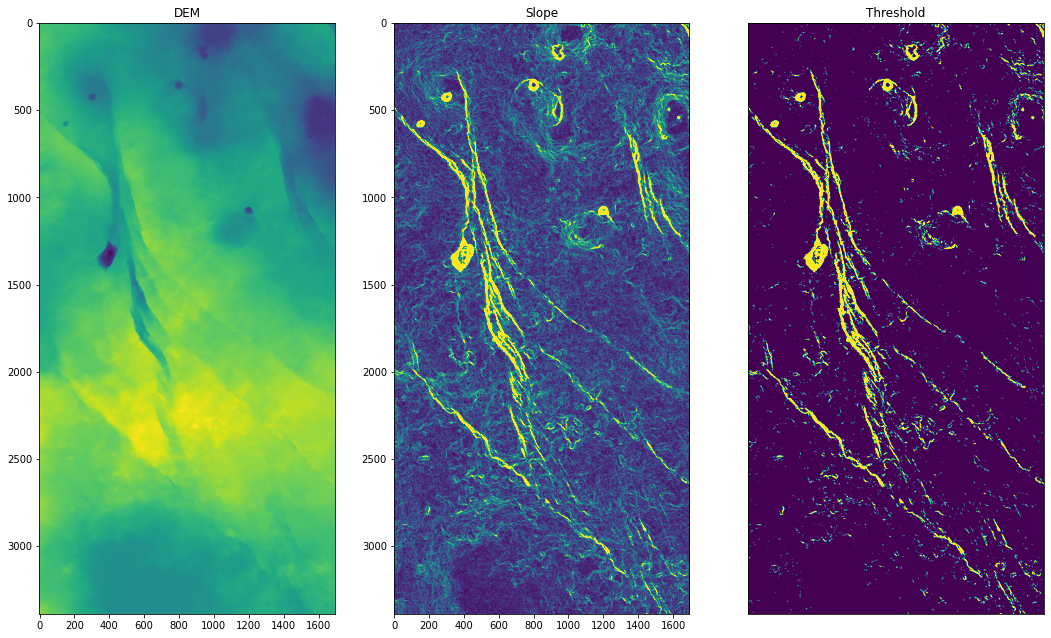

In [20]:
slope = np.gradient(DEM)

dx = slope[0]
dy = slope[1]

dx_abs = abs(dx)
dy_abs = abs(dy)

slope_abs = dx_abs+dy_abs

threshold = simple_threshold_binary(slope_abs, 0.4)


fig, axs = plt.subplots(1, 3, figsize=(18,12))
axs[0].imshow(DEM)
axs[0].set_title('DEM')
axs[1].imshow(slope_abs, vmax=0.5)
axs[1].set_title('Slope')
axs[2].imshow(threshold, vmax=0.5)
axs[2].set_title('Threshold')
plt.show()

and we calculate the edges, too:

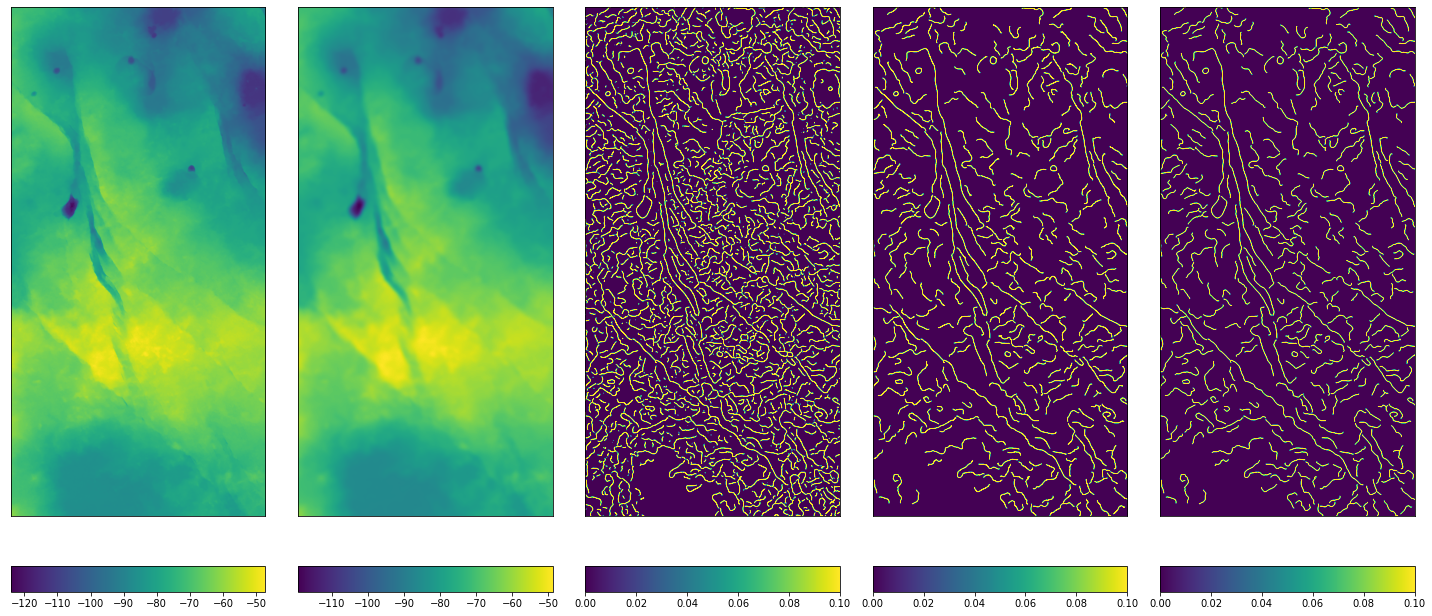

In [37]:
smoothed = filters.gaussian(DEM, sigma=10)
edges = feature.canny(smoothed)
cleaned = morphology.remove_small_objects(edges, connectivity=2, min_size=100).astype('uint8')
skeleton = skeleton_guo_hall(cleaned)


fig, axs = plt.subplots(1, 5, figsize=(20,10))
im0 = axs[0].imshow(DEM)
axs[0].set_xticks([])
axs[0].set_yticks([])
divider = make_axes_locatable(axs[0])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im0, cax=cax, orientation="horizontal")


im1 = axs[1].imshow(smoothed)
axs[1].set_xticks([])
axs[1].set_yticks([])
divider = make_axes_locatable(axs[1])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im1, cax=cax, orientation="horizontal")


im2 = axs[2].imshow(edges, vmin=0, vmax=0.1)
axs[2].set_xticks([])
axs[2].set_yticks([])
divider = make_axes_locatable(axs[2])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im2, cax=cax, orientation="horizontal")


im3 = axs[3].imshow(cleaned, vmin=0, vmax=0.1)
axs[3].set_xticks([])
axs[3].set_yticks([])
divider = make_axes_locatable(axs[3])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im3, cax=cax, orientation="horizontal")

im4 = axs[4].imshow(skeleton, vmin=0, vmax=0.1)
axs[4].set_xticks([])
axs[4].set_yticks([])
divider = make_axes_locatable(axs[4])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im4, cax=cax, orientation="horizontal")

plt.tight_layout()
plt.show()

I found that the edges work best for the extraction, but we will use the slope later on to eliminate some of the mispicks.

Next we label the connected components in the image:

These components become the nodes of our graph G:

In [38]:
G = nx.Graph()

node = 0
for comp in range(1,ret):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1    

And we connect them within each component (this takes a minute):

In [39]:
for comp in range(1,ret): 
    
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  
    
    
    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):
            if dm[n,m]<1.5 and n != m:
                G.add_edge(nodes[n],nodes[m])

Now we can label the graph and look at our result:

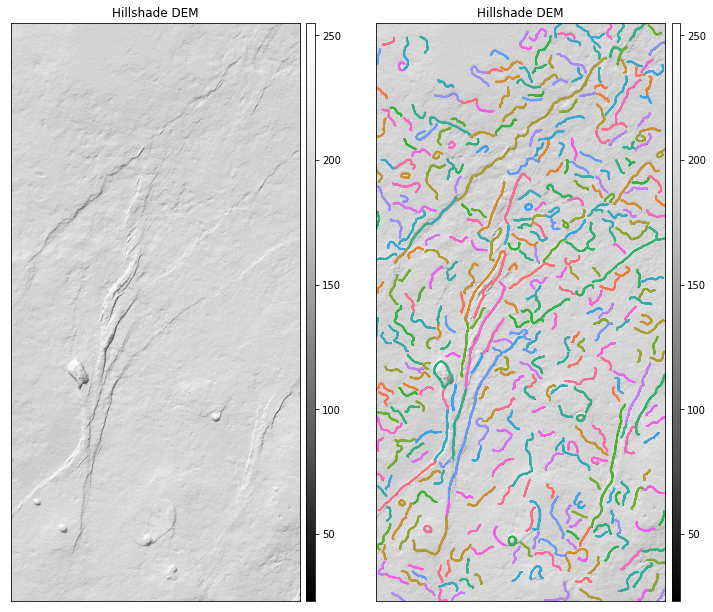

In [40]:
G = label_components(G)

# Plot arrays
fig, axs = plt.subplots(1, 2, figsize=(12,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=True, title="Hillshade DEM", figsize=(10, 6), ax=axs[0],
)
ep.plot_bands(
    hillshade, cbar=True, title="Hillshade DEM", figsize=(10, 6), ax=axs[1],
)
plot_components(G, ax=axs[1], node_size=0.75, label=False)

axs[1].set_xlim([0, DEM.shape[1]])
axs[1].set_ylim([0, DEM.shape[0]])

plt.show()

Looks like we capture the faults, but also some other structures. Let's try to 

But first we fix some minor issues in the network:

In [ ]:
G = remove_self_edge(G)
G = remove_triangles(G)
G = remove_cycles_hard(G)
G = label_components(G)

Now we will try to use the slope (threshold) to remove the smaller mispicks. First, we extract this attribute along our graph:

In [ ]:
G = compute_curvature(G, 3, 2)


# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(8,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)


ep.plot_bands(
    hillshade, cbar=False, title="Hillshade DEM", ax=ax,
)
plot_attribute(G, 'max_curv', ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([0, DEM.shape[0]])

plt.show()

Nice - we see higher slope values on our faults. Now we can use them to filter then out, but first let's average them across the faults:

In [ ]:
for cc in nx.connected_components(G):
  mean_curv = np.nanmean([G.nodes[node]['max_curv'] for node in cc])
  for node in cc:
    G.nodes[node]['mean_max_curv'] = mean_curv

# Plot arrays
fig, ax = plt.subplots(1, 1, figsize=(8,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)


ep.plot_bands(
    hillshade, cbar=False, title="Hillshade DEM", ax=ax,
)
plot_attribute(G, 'mean_max_curv', vmax=0.5, ax=ax)

ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([0, DEM.shape[0]])

plt.show()

Now we can pick a threshold value (e.g. 0.3) to remove the mispicks:

In [ ]:
G_filter = G.copy()

threshold_value = 0.2

removals = []
for cc in nx.connected_components(G_filter):
  mean_curv = np.nanmean([G_filter.nodes[node]['mean_max_curv'] for node in cc])

  if mean_curv > threshold_value:
    for node in cc:
      removals.append(node)

G_filter.remove_nodes_from(removals)

In [ ]:
# Plot arrays
fig, axs = plt.subplots(1, 3, figsize=(18,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=True, title="Hillshade DEM", figsize=(10, 6), ax=axs[0],
)


ep.plot_bands(
    hillshade, cbar=True, title="Before filtering", figsize=(10, 6), ax=axs[1],
)
plot_components(G, label=False, node_size=0.75, ax=axs[1])

axs[1].set_xlim([0, DEM.shape[1]])
axs[1].set_ylim([0, DEM.shape[0]])


ep.plot_bands(
    hillshade, cbar=True, title="After filtering", figsize=(10, 6), ax=axs[2],
)
plot_components(G_filter, label=False, node_size=0.75, ax=axs[2])

axs[2].set_xlim([0, DEM.shape[1]])
axs[2].set_ylim([0, DEM.shape[0]])


plt.show()

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon



fig, ax = plt.subplots(1, 1, figsize=(18,12))
ep.plot_bands(es.hillshade(DEM), cbar=False, ax=ax)
plot_components(G_filter, ax=ax, node_size=0.75, label=True)
ax.set_xlim([0, DEM.shape[1]])
ax.set_ylim([0, DEM.shape[0]])




def connect_tips(G, distance, opening, plot=True):
  
  G = G.copy()

  for node in G:
      
      
      if G.degree(node) == 1:
          
          
          # Get location
          x, y = G.nodes[node]['pos']
          
          # plt.scatter(x, y, color='yellow')
          
          # Get 10th neighbor
          neighbors = nx.single_source_shortest_path_length(G, node, cutoff=10)
          neighbors = sorted(neighbors.items())
          
          if neighbors[0][0] == node:
              neighbor  = neighbors[-1][0]
          elif neighbors[-1][0] == node:
              neighbor  = neighbors[0][0]
          #else:
              #print('Neighbor not found')
              

          # Get location of neighbor
          x_n, y_n = G.nodes[neighbor]['pos']
          
          # Compute direction
          dx = x-x_n
          dy = y-y_n
          
          normal = [dx, dy]/np.linalg.norm([dx, dy])
          dx = normal[0]
          dy = normal[1]
          
          # Compute extension point
          x_e = x+dx*distance
          y_e = y+dy*distance
          
          # plt.scatter(x_e, y_e, color='red')
          # plt.show()
          
          # Compute perpendicular direction
          dx_p = dy
          dy_p = -dx
          
          
          x_top = x_e + dx_p*opening
          y_top = y_e + dy_p*opening
          
          # plt.scatter(x_top, y_top, color='green')
          # plt.axis('equal')
          # plt.show()        
          
          x_bottom = x_e - dx_p*opening
          y_bottom = y_e - dy_p*opening
          
          # plt.scatter(x_bottom, y_bottom, color='green')
          # plt.axis('equal')
          # plt.show()
          
          polygon = Polygon([(x,y), (x_top, y_top), (x_bottom, y_bottom)])
          
          if plot:
              plt.plot(*polygon.exterior.xy, color='red')
          
          
    
    
          for another in G:
              if G.degree(another)==1 and G.nodes[node]['component'] != G.nodes[another]['component']:
                  point = Point(*G.nodes[another]['pos'])
                  if polygon.contains(point):
                      print('Connect component ' + str(G.nodes[node]['component']) + ' to ' + str(G.nodes[another]['component']))
                      G.add_edge(node, another)

  return G

distance = 45 # How far away from the fault tip can we go to connect to other tip
opening = 30 # How wide is the opening angle to consider (it's not degrees)

G_connect = connect_tips(G_filter, distance, opening, plot=True)

plt.show()

G_connect = label_components(G_connect)

The red triangles show the areas around the fault tips where we can connect them.

In [ ]:
# Plot arrays
fig, axs = plt.subplots(1, 3, figsize=(18,12), sharey=True)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(DEM)

ep.plot_bands(
    hillshade, cbar=True, title="Hillshade DEM", figsize=(10, 6), ax=axs[0],
)


ep.plot_bands(
    hillshade, cbar=True, title="Before connecting", figsize=(10, 6), ax=axs[1],
)
plot_components(G_filter, label=True, node_size=0.75, ax=axs[1])

axs[1].set_xlim([0, DEM.shape[1]])
axs[1].set_ylim([0, DEM.shape[0]])


ep.plot_bands(
    hillshade, cbar=True, title="After connecting", figsize=(10, 6), ax=axs[2],
)
plot_components(G_connect, node_size=0.75, ax=axs[2])

axs[2].set_xlim([0, DEM.shape[1]])
axs[2].set_ylim([0, DEM.shape[0]])


plt.show()

Nice! We can see that we were able to connect the components 39, 67 and 30 to form component 3.

In [ ]:
G = compute_strikes(G, 3)

for node in G:
  G.nodes[node]['strike'] = np.mean([G.])

for component in nx.connected_components(G):
    strikes = [G.nodes]